Authors: Antoine A. Ruzette, Simon F. Nørrelykke
Date: 2024-07-25

This notebook plots the cell-level pixel intensity distribution of Ki67, and fits the best weighted least-square distribution from a population of common distributions on a whole batch of images. It uses the `Fitter` library. 

Contains the code to plot data from Ki67 images only. 

In [2]:
import os
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import poisson
from scipy.optimize import curve_fit
from scipy.stats import expon
from scipy.stats import gamma
from scipy.stats import lognorm
from scipy.stats import burr
from fitter import Fitter, get_common_distributions, get_distributions
import natsort

#os.chdir('/Users/antoine/Harvard/IAC/NinaKozlova/20240111_AsPC_pNDRG1/Results')

# colorblind-friendly colors
CB_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']

# Intensity distributions for each channel

## Linear scale distributions

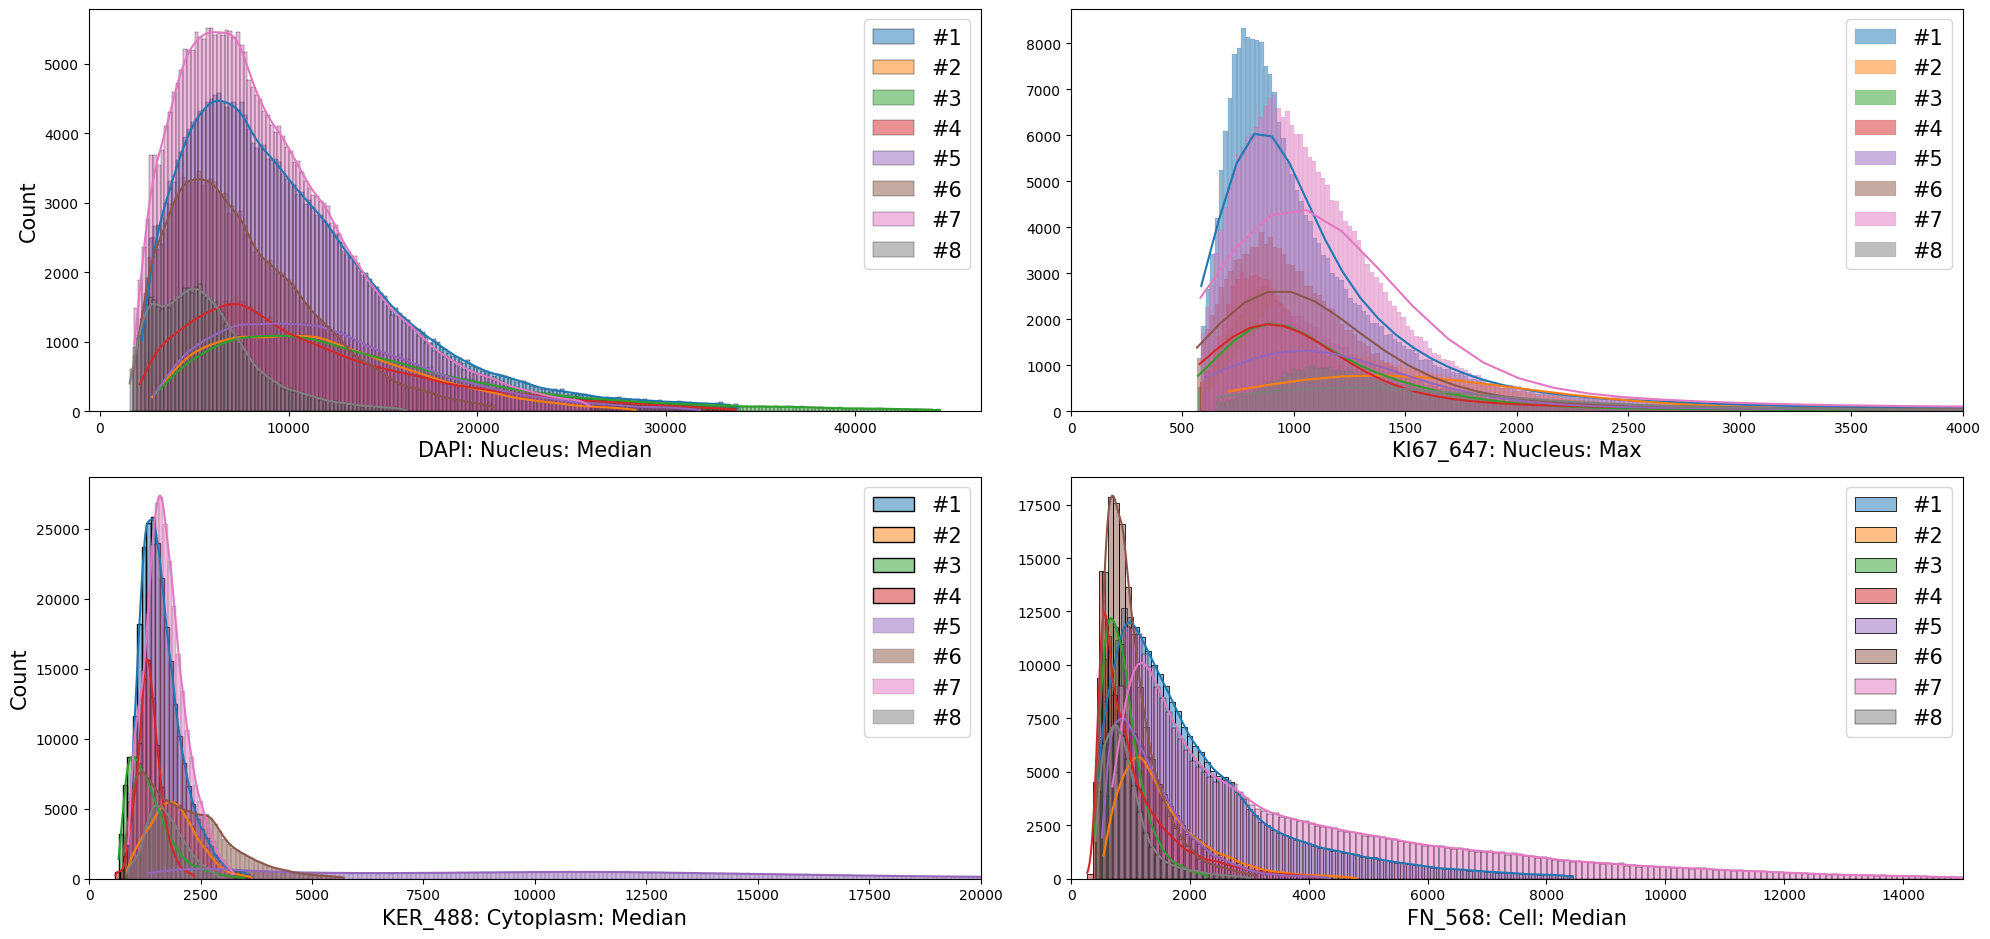

In [17]:
# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = np.sort(csv_files)
# Specify the columns you want to load
columns_to_load = ['DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'KI67_647: Nucleus: Max', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

dfs = []

for idx, image in enumerate(csv_files):

    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"

    # Remove outliers using IQR for DAPI intensities
    p01_dapi = df['DAPI: Nucleus: Median'].quantile(0.01)
    p99_dapi = df['DAPI: Nucleus: Median'].quantile(0.99)
    # Remove outliers using IQR for pNDRG1_647 intensities
    p01_pNDRG1 = df['KI67_647: Nucleus: Max'].quantile(0.01)
    p99_pNDRG1 = df['KI67_647: Nucleus: Max'].quantile(0.99)
    # Remove outliers using IQR for KER_488 intensities
    p01_KER = df['KER_488: Cytoplasm: Median'].quantile(0.01)
    p99_KER = df['KER_488: Cytoplasm: Median'].quantile(0.99)
    # Remove outliers using IQR for KER_488 intensities
    p01_FN = df['FN_568: Cell: Median'].quantile(0.01)
    p99_FN = df['FN_568: Cell: Median'].quantile(0.99)
    
    df_no_outlier = df[(df['KI67_647: Nucleus: Max'] >= p01_pNDRG1) & 
                       (df['KI67_647: Nucleus: Max'] <= p99_pNDRG1) &
                       (df['KER_488: Cytoplasm: Median'] >= p01_KER) &
                       (df['KER_488: Cytoplasm: Median'] <= p99_KER) &
                       (df['FN_568: Cell: Median'] >= p01_FN) &
                       (df['FN_568: Cell: Median'] <= p99_FN) & 
                       (df['DAPI: Nucleus: Median'] >= p01_dapi) & 
                       (df['DAPI: Nucleus: Median'] <= p99_dapi)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['DAPI: Nucleus: Median'], binwidth=200, kde=True, ax=axs[0, 0], label=f'{gem_number}', alpha=0.5)
    # Plot yH2AX intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['KI67_647: Nucleus: Max'], binwidth=20, kde=True, ax=axs[0, 1], label=f'{gem_number}', alpha=0.5)
    # Plot KER intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['KER_488: Cytoplasm: Median'], binwidth=100, kde=True, ax=axs[1, 0], label=f'{gem_number}', alpha=0.5)
    # Plot FN intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['FN_568: Cell: Median'], binwidth=100, kde=True, ax=axs[1, 1], label=f'{gem_number}', alpha=0.5)

    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

# Set log scale
for ax_row in axs:
    for ax in ax_row:
        ax.set_yscale('linear')
        ax.set_ylabel('')

axs[0, 0].legend(fontsize=15)
axs[0, 1].legend(fontsize=15)
axs[1, 0].legend(fontsize=15)
axs[1, 1].legend(fontsize=15)

axs[0, 0].set_ylabel('Count', fontsize=15)
axs[0, 1].set_ylabel('')
axs[1, 0].set_ylabel('Count', fontsize=15)
axs[1, 1].set_ylabel('')

axs[0, 0].set_xlabel('DAPI: Nucleus: Median', fontsize=15)
axs[0, 1].set_xlabel('KI67_647: Nucleus: Max', fontsize=15)
axs[1, 0].set_xlabel('KER_488: Cytoplasm: Median', fontsize=15)
axs[1, 1].set_xlabel('FN_568: Cell: Median', fontsize=15)
axs[1, 1].set_xlim([0, 15000])
axs[0, 1].set_xlim([0, 4000])
axs[1, 0].set_xlim([0, 20000])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
#axs[1, 1].set_xlim([0, 15000])

# Show the plots
# plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_distributions_allchannels_allcells_semilogy.png", dpi=300)
plt.show()


## Semi-logy distributions

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_86780/577426319.py:18: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)


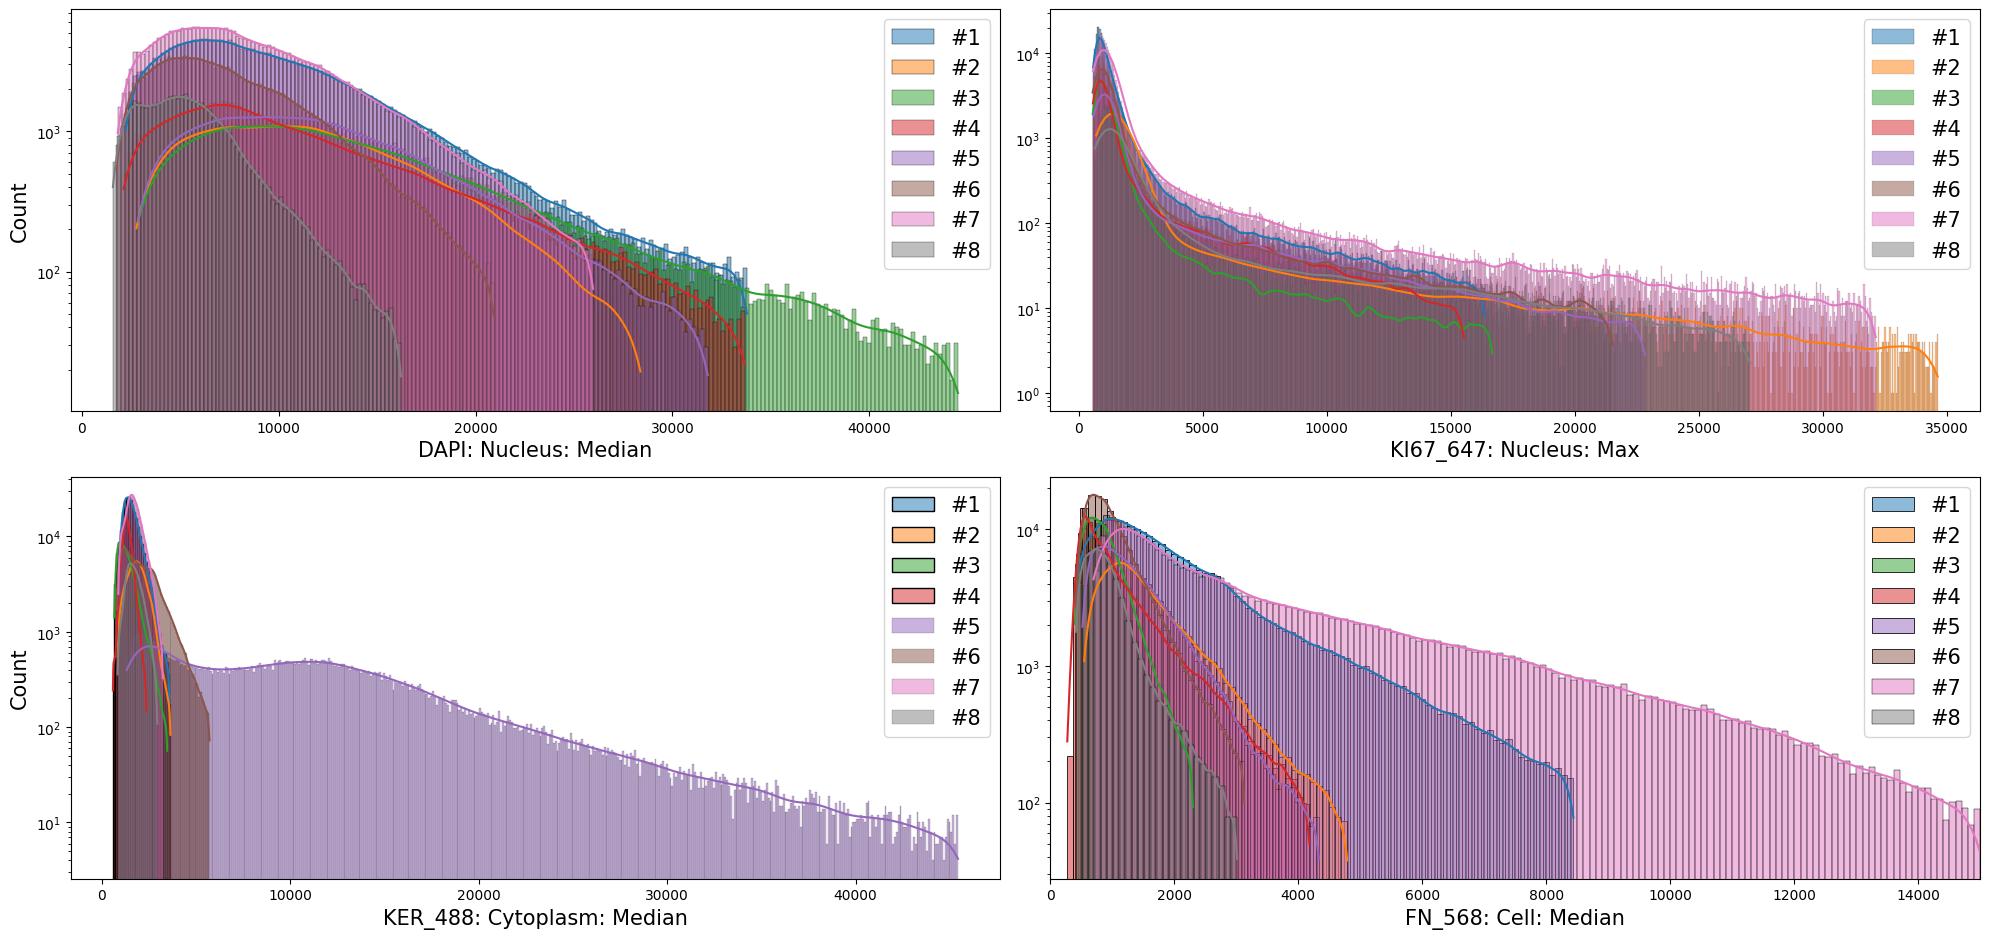

In [12]:
# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = np.sort(csv_files)
# Specify the columns you want to load
columns_to_load = ['DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'KI67_647: Nucleus: Max', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

dfs = []

for idx, image in enumerate(csv_files):

    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"

    # Remove outliers using IQR for DAPI intensities
    p01_dapi = df['DAPI: Nucleus: Median'].quantile(0.01)
    p99_dapi = df['DAPI: Nucleus: Median'].quantile(0.99)
    # Remove outliers using IQR for pNDRG1_647 intensities
    p01_pNDRG1 = df['KI67_647: Nucleus: Max'].quantile(0.01)
    p99_pNDRG1 = df['KI67_647: Nucleus: Max'].quantile(0.99)
    # Remove outliers using IQR for KER_488 intensities
    p01_KER = df['KER_488: Cytoplasm: Median'].quantile(0.01)
    p99_KER = df['KER_488: Cytoplasm: Median'].quantile(0.99)
    # Remove outliers using IQR for KER_488 intensities
    p01_FN = df['FN_568: Cell: Median'].quantile(0.01)
    p99_FN = df['FN_568: Cell: Median'].quantile(0.99)
    
    df_no_outlier = df[(df['KI67_647: Nucleus: Max'] >= p01_pNDRG1) & 
                       (df['KI67_647: Nucleus: Max'] <= p99_pNDRG1) &
                       (df['KER_488: Cytoplasm: Median'] >= p01_KER) &
                       (df['KER_488: Cytoplasm: Median'] <= p99_KER) &
                       (df['FN_568: Cell: Median'] >= p01_FN) &
                       (df['FN_568: Cell: Median'] <= p99_FN) & 
                       (df['DAPI: Nucleus: Median'] >= p01_dapi) & 
                       (df['DAPI: Nucleus: Median'] <= p99_dapi)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['DAPI: Nucleus: Median'], binwidth=200, kde=True, ax=axs[0, 0], label=f'{gem_number}', alpha=0.5)
    # Plot yH2AX intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['KI67_647: Nucleus: Max'], binwidth=50, kde=True, ax=axs[0, 1], label=f'{gem_number}', alpha=0.5)
    # Plot KER intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['KER_488: Cytoplasm: Median'], binwidth=100, kde=True, ax=axs[1, 0], label=f'{gem_number}', alpha=0.5)
    # Plot FN intensity distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['FN_568: Cell: Median'], binwidth=100, kde=True, ax=axs[1, 1], label=f'{gem_number}', alpha=0.5)

    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

# Set log scale
for ax_row in axs:
    for ax in ax_row:
        ax.set_yscale('log')
        ax.set_ylabel('')

axs[0, 0].legend(fontsize=15)
axs[0, 1].legend(fontsize=15)
axs[1, 0].legend(fontsize=15)
axs[1, 1].legend(fontsize=15)

axs[0, 0].set_ylabel('Count', fontsize=15)
axs[0, 1].set_ylabel('')
axs[1, 0].set_ylabel('Count', fontsize=15)
axs[1, 1].set_ylabel('')

axs[0, 0].set_xlabel('DAPI: Nucleus: Median', fontsize=15)
axs[0, 1].set_xlabel('KI67_647: Nucleus: Max', fontsize=15)
axs[1, 0].set_xlabel('KER_488: Cytoplasm: Median', fontsize=15)
axs[1, 1].set_xlabel('FN_568: Cell: Median', fontsize=15)
# axs[1, 1].set_xlim([0, 15000])
# axs[0, 1].set_xlim([0, 4000])
# axs[1, 0].set_xlim([0, 20000])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
axs[1, 1].set_xlim([0, 15000])

# Show the plots
# plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_distributions_allchannels_allcells_semilogy.png", dpi=300)
plt.show()


## Exploring non-gaussian distributions using the `Fitter` library

### Ki67_647 distributions

#### Finding the right distributions; result = burr (8 out of 8)

#1


2024-06-13 12:22:13.718 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-06-13 12:22:13.821 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=3e-06)


633


2024-06-13 12:22:13.855 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-06-13 12:22:15.309 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 12:22:15.977 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=5e-06)
2024-06-13 12:22:16.438 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-06-13 12:22:17.744 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1e-06)
2024-06-13 12:22:17.812 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)
2024-06-13 12:22:21.951 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'burr': {'c': 2.8330293571364606, 'd': 637.293865600355, 'loc': -2.370571053584964, 'scale': 95.27104144793918}}
#2


2024-06-13 12:22:23.206 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-06-13 12:22:23.231 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)
2024-06-13 12:22:23.249 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


1358


2024-06-13 12:22:23.640 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 12:22:23.798 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-06-13 12:22:23.897 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-06-13 12:22:24.389 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-06-13 12:22:24.409 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.0)
2024-06-13 12:22:25.607 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'burr': {'c': 2.212231927147526, 'd': 2594.5890840189295, 'loc': 74.41738396363365, 'scale': 36.101005292615056}}
#3
2003


2024-06-13 12:22:26.166 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-06-13 12:22:26.191 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=3e-06)
2024-06-13 12:22:26.261 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-06-13 12:22:26.711 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 12:22:27.005 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=5e-06)
2024-06-13 12:22:27.168 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-06-13 12:22:27.523 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1e-06)
2024-06-13 12:22:27.592 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with 

{'burr': {'c': 2.984174807725722, 'd': 547.5667532222799, 'loc': 0.14283518318506738, 'scale': 113.31809800420893}}


2024-06-13 12:22:29.531 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)


#4
2601


2024-06-13 12:22:29.553 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=4e-06)
2024-06-13 12:22:29.579 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=1e-06)
2024-06-13 12:22:29.947 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=1e-06)
2024-06-13 12:22:30.265 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=2e-06)
2024-06-13 12:22:30.352 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=2e-06)
2024-06-13 12:22:30.812 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=2e-06)
2024-06-13 12:22:30.861 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=2e-06)
2024-06-13 12:22:32.313 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution wi

{'burr': {'c': 2.5283804994417025, 'd': 654.4327973350721, 'loc': -0.9551488545260001, 'scale': 72.39739636676006}}
#5


2024-06-13 12:22:32.920 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-06-13 12:22:32.949 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2e-06)
2024-06-13 12:22:32.970 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


3491


2024-06-13 12:22:33.376 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=1e-06)
2024-06-13 12:22:33.681 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=1e-06)
2024-06-13 12:22:33.745 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-06-13 12:22:34.169 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-06-13 12:22:34.243 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)
2024-06-13 12:22:35.531 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'burr': {'c': 2.284534432987846, 'd': 680.1949208273782, 'loc': -1.7334250769815993, 'scale': 62.10741422045488}}


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_86780/3542590890.py:22: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)


#6


2024-06-13 12:22:36.490 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-06-13 12:22:36.523 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2e-06)
2024-06-13 12:22:36.557 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


4330


2024-06-13 12:22:37.145 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 12:22:37.516 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=4e-06)
2024-06-13 12:22:37.706 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-06-13 12:22:38.490 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1e-06)
2024-06-13 12:22:38.551 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)
2024-06-13 12:22:40.821 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'burr': {'c': 2.5229456180488503, 'd': 612.1328029148133, 'loc': -2.0609196096607096, 'scale': 75.20388265300284}}
#7


2024-06-13 12:22:42.318 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-06-13 12:22:42.404 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2e-06)


5592


2024-06-13 12:22:42.457 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-06-13 12:22:43.775 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 12:22:44.725 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-06-13 12:22:45.097 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-06-13 12:22:46.694 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)
2024-06-13 12:22:46.706 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-06-13 12:22:51.365 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'burr': {'c': 2.301464868925004, 'd': 648.491709761646, 'loc': -1.6787063774466713, 'scale': 61.68973814023583}}
#8


2024-06-13 12:22:51.873 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-06-13 12:22:51.898 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)
2024-06-13 12:22:51.911 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


6649


2024-06-13 12:22:52.237 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-06-13 12:22:52.402 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-06-13 12:22:52.448 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-06-13 12:22:52.720 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-06-13 12:22:52.736 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)
2024-06-13 12:22:53.542 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'burr': {'c': 1.8975548804792375, 'd': 711.6426237676424, 'loc': -2.100438251906386, 'scale': 42.635358866628565}}


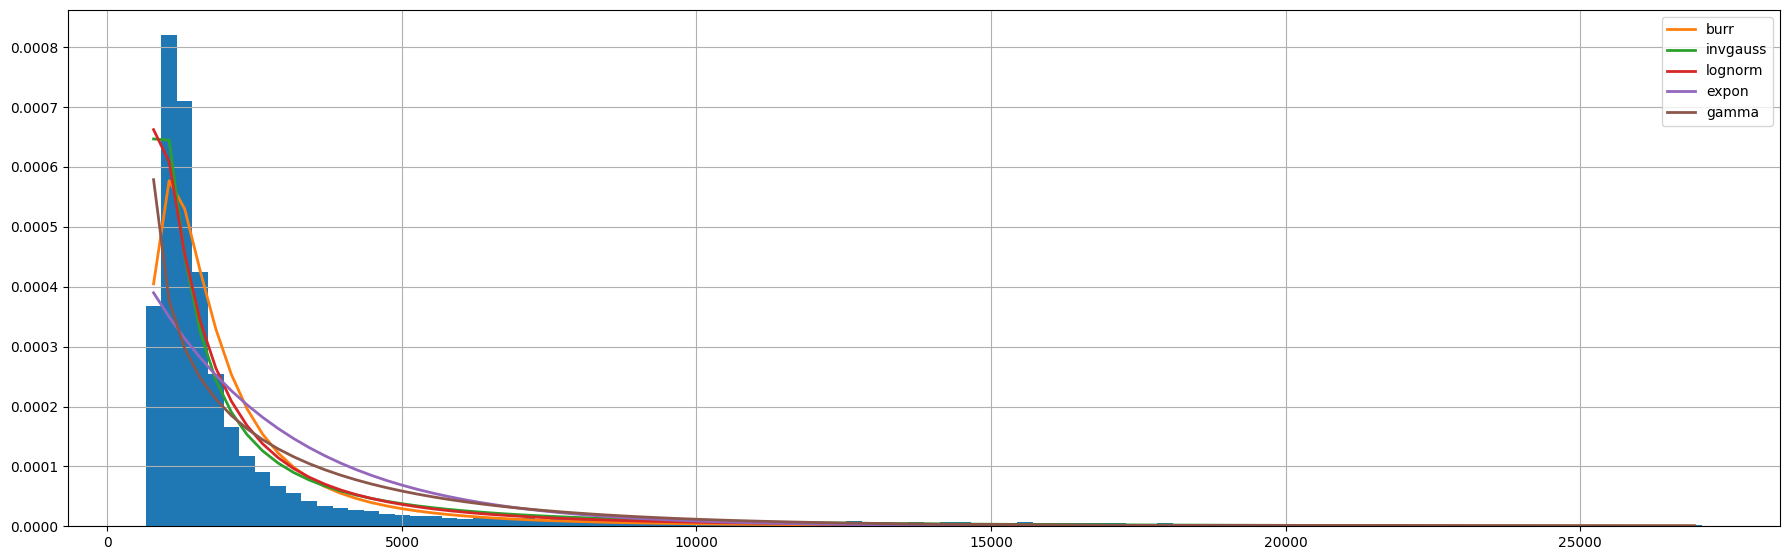

In [19]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/exploratory_data"

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
csv_files = np.sort(csv_files)
# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'KI67_647: Nucleus: Max', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']

fig, axs = plt.subplots(1, 4, figsize=(18, 6))

dfs = []
params_reference = None
threshold_reference = 1

for idx, image in enumerate(csv_files):

    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"
    print(gem_number)

    # Remove outliers using IQR for pNDRG1_647 intensities
    p01_pNDRG1 = df['KI67_647: Nucleus: Max'].quantile(0.01)
    p99_pNDRG1 = df['KI67_647: Nucleus: Max'].quantile(0.99)
    
    df_no_outlier = df[(df['KI67_647: Nucleus: Max'] >= p01_pNDRG1) & 
                       (df['KI67_647: Nucleus: Max'] <= p99_pNDRG1)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['KI67_647: Nucleus: Max'], binwidth=25, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.5)

    bins = []
    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins.append(axs[0].patches[-1].get_x() + (axs[0].patches[-1].get_width()))
    bins = np.sort(bins)
    
    print(len(bins))

    f = Fitter(df_no_outlier['KI67_647: Nucleus: Max'],
               distributions= ["gamma", "invgauss", "lognorm", "beta", "burr",  "expon", "rayleigh", "chi2", "exponpow"]
               )
    f.fit()
    summary = f.summary(clf=True)
    print(f.get_best(method = 'sumsquare_error'))
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('KI67_647: Nucleus: Max', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_distributions_allchannels_allcells_linear.png", dpi=300)
plt.show()

#1


2024-06-13 12:24:41.419 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_86780/18022888.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv
{'c': 2.5229456180488503, 'd': 612.1328029148133, 'loc': -2.0609196096607096, 'scale': 75.20388265300284}
#2


2024-06-13 12:24:50.374 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_86780/18022888.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv
{'c': 2.8330293571364606, 'd': 637.293865600355, 'loc': -2.370571053584964, 'scale': 95.27104144793918}
Translated threshold for img1: 1713.80
Scaled threshold for img1: 2407.23
#3


2024-06-13 12:24:53.416 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_86780/18022888.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv
{'c': 2.284534432987846, 'd': 680.1949208273782, 'loc': -1.7334250769815993, 'scale': 62.10741422045488}
Translated threshold for img2: 2302.82
Scaled threshold for img2: 1569.09
#4


2024-06-13 12:25:03.783 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_86780/18022888.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv
{'c': 2.301464868925004, 'd': 648.491709761646, 'loc': -1.6787063774466713, 'scale': 61.68973814023583}
Translated threshold for img3: 2181.57
Scaled threshold for img3: 1558.58
#5


2024-06-13 12:25:06.013 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_86780/18022888.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv
{'c': 1.8975548804792375, 'd': 711.6426237676424, 'loc': -2.100438251906386, 'scale': 42.635358866628565}
Translated threshold for img4: 3383.41
Scaled threshold for img4: 1076.24
#6


2024-06-13 12:25:09.099 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_86780/18022888.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv
{'c': 2.212231927147526, 'd': 2594.5890840189295, 'loc': 74.41738396363365, 'scale': 36.101005292615056}
Translated threshold for img5: 2835.65
Scaled threshold for img5: 987.49
#7


2024-06-13 12:25:12.256 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_86780/18022888.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv
{'c': 2.984174807725722, 'd': 547.5667532222799, 'loc': 0.14283518318506738, 'scale': 113.31809800420893}
Translated threshold for img6: 1675.92
Scaled threshold for img6: 2866.19
#8


2024-06-13 12:25:15.450 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_86780/18022888.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv
{'c': 2.5283804994417025, 'd': 654.4327973350721, 'loc': -0.9551488545260001, 'scale': 72.39739636676006}
Translated threshold for img7: 1866.16
Scaled threshold for img7: 1830.12


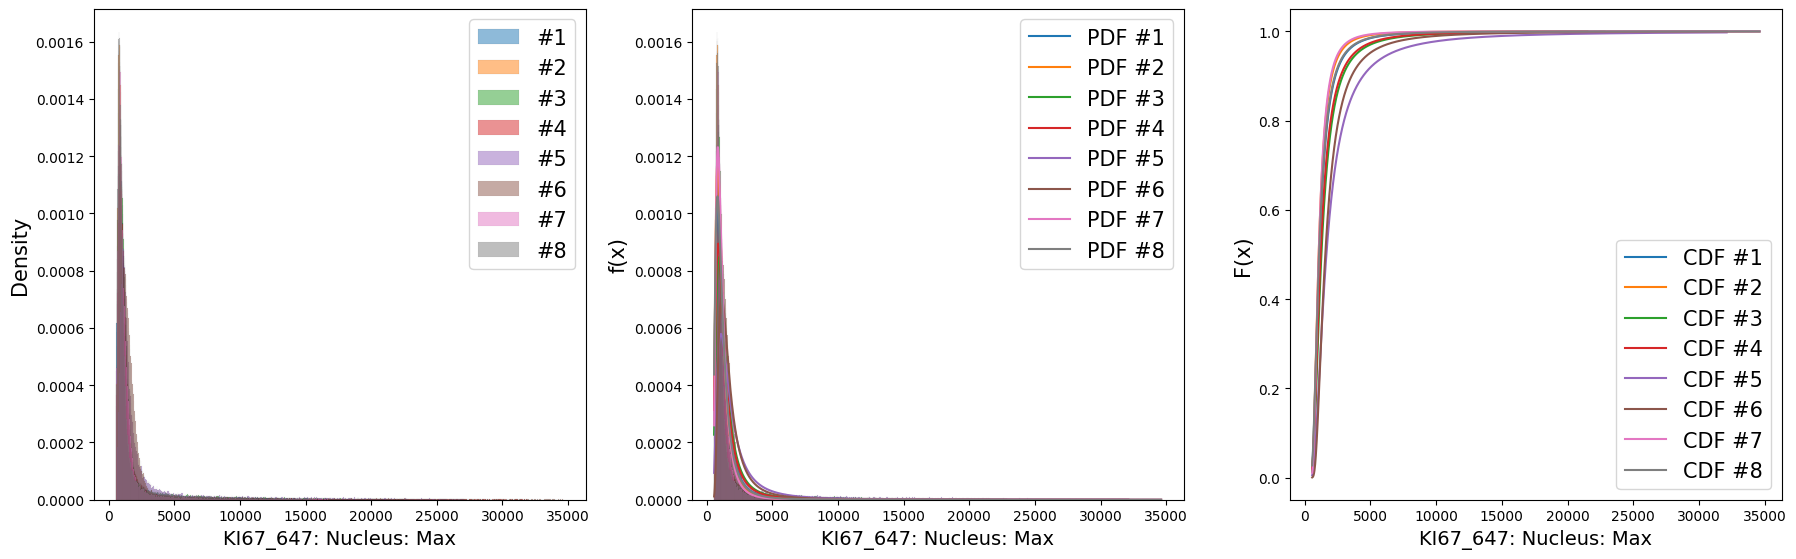

In [21]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/exploratory_data"

# Specify the columns you want to load
columns_to_load = ['DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'KI67_647: Nucleus: Max', 
                   'FN_568: Cell: Median']


control_replicates = ["Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv", 
                      ]

fig, axs = plt.subplots(1, 4, figsize=(24, 6))

dfs = []
params_reference = None
threshold_reference = 1900

for idx, image in enumerate(control_replicates):

    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"
    print(gem_number)

    # Remove outliers using IQR for pNDRG1_647 intensities
    p01_pNDRG1 = df['KI67_647: Nucleus: Max'].quantile(0.01)
    p99_pNDRG1 = df['KI67_647: Nucleus: Max'].quantile(0.99)

    
    df_no_outlier = df[(df['KI67_647: Nucleus: Max'] >= p01_pNDRG1) & 
                       (df['KI67_647: Nucleus: Max'] <= p99_pNDRG1)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    hist_plot = sns.histplot(df_no_outlier['KI67_647: Nucleus: Max'], binwidth=25, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.5, stat='density')

    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins = np.sort(bins)
    
    f = Fitter(df_no_outlier['KI67_647: Nucleus: Max'],
               distributions=['burr']
               )
    
    f.fit()
    summary = f.summary(clf=False)
    sse = "{:.2e}".format(summary['sumsquare_error'][0])
    params = f.get_best(method = 'sumsquare_error')
    params = params.get('burr')
    print(image)
    print(params)

    if idx == 0: 
        params_reference = params
    else: 
        # Get the percentile for this threshold
        cdf_reference = burr.cdf(threshold_reference, **params_reference)
        # Translate this percentile onto the distribution of reference by using the inverse CDF and get back a value from the percentile
        translated_threshold = burr.ppf(cdf_reference, **params)       
        print(f"Translated threshold for img{idx}: {translated_threshold:.2f}")
        # Scale the data point using the parameters of the target distribution
        scaled_threshold = (threshold_reference - params_reference['loc']) * (params['scale'] / params_reference['scale']) + params['loc']
        print(f"Scaled threshold for img{idx}: {scaled_threshold:.2f}")

    cdf_values = burr.cdf(bins, **params)
    pdf_values = burr.pdf(bins, **params)

    # Plot the line of the log-normal distribution
    sns.histplot(df_no_outlier['KI67_647: Nucleus: Max'], binwidth=25, kde=False, ax=axs[1], alpha=0.5, stat='density')
    axs[1].plot(bins, pdf_values, label=f"PDF {gem_number}")
    axs[2].plot(bins, cdf_values, label=f'CDF {gem_number}')
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('KI67_647: Nucleus: Max', fontsize=14)

axs[1].legend(fontsize=15)
axs[1].set_ylabel(r'f(x)', fontsize=15)
axs[1].set_xlabel('KI67_647: Nucleus: Max', fontsize=14)

axs[2].legend(fontsize=15)
axs[2].set_ylabel(r'F(x)', fontsize=15)
axs[2].set_xlabel('KI67_647: Nucleus: Max', fontsize=14)

axs[3].remove()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
# plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_pNDRG1_SW1990_lognormal.png", dpi=300)
plt.show()

### KER_488 distributions

#### Finding the right distribution; result: lognorm (3 out of 8)

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1189043513.py:31: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
2024-04-25 17:56:20.189 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1e-06)
2024-04-25 17:56:20.189 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-06)
2024-04-25 17:56:20.241 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)


#1
50


2024-04-25 17:56:20.350 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 17:56:20.921 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 17:56:21.349 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.0)
2024-04-25 17:56:21.573 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 17:56:21.635 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-04-25 17:56:21.758 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-04-25 17:56:25.824 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'beta': {'a': 1.3680056703118537, 'b': 5.165116287518936, 'loc': 767.3377277188882, 'scale': 6445.131958238757}}


2024-04-25 17:56:27.165 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=2e-06)
2024-04-25 17:56:27.170 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=8e-06)


#2
28


2024-04-25 17:56:27.242 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)
2024-04-25 17:56:27.598 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 17:56:28.338 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 17:56:30.160 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-04-25 17:56:30.567 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=3e-06)
2024-04-25 17:56:31.133 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 17:56:31.474 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=2.5e-05)
2024-04-25 17:56:39.109 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with e

{'lognorm': {'s': 0.43515928988900693, 'loc': 576.4529130422418, 'scale': 972.4919093726185}}


2024-04-25 17:56:39.640 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-04-25 17:56:39.642 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-04-25 17:56:39.673 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)


#3
469


2024-04-25 17:56:39.728 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 17:56:40.088 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 17:56:40.415 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-04-25 17:56:40.461 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-04-25 17:56:40.578 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 17:56:41.137 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=0.0)
2024-04-25 17:56:43.184 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'exponpow': {'b': 0.8283459837591356, 'loc': 1323.9999999999998, 'scale': 17004.908100365705}}


2024-04-25 17:56:44.391 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1e-05)
2024-04-25 17:56:44.405 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1e-06)


#4
493


2024-04-25 17:56:44.667 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)
2024-04-25 17:56:45.098 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 17:56:46.254 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 17:56:47.507 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 17:56:48.151 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-04-25 17:56:48.688 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=1.6e-05)
2024-04-25 17:56:49.060 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=2.7e-05)
2024-04-25 17:56:57.821 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with err

{'lognorm': {'s': 0.2572099923502974, 'loc': -47.31216029253392, 'scale': 1714.6069038332787}}
#5


2024-04-25 17:56:58.124 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1.5e-05)
2024-04-25 17:56:58.164 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1e-06)
2024-04-25 17:56:58.213 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)


514


2024-04-25 17:56:58.315 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 17:56:58.654 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 17:56:58.819 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-04-25 17:56:58.923 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 17:56:59.001 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=4e-06)
2024-04-25 17:56:59.132 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=3.2e-05)
2024-04-25 17:57:00.537 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=1e-06)


{'chi2': {'df': 23.794700075786814, 'loc': 259.4184363811176, 'scale': 61.25865996079789}}


2024-04-25 17:57:01.146 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-04-25 17:57:01.154 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=8e-06)


#6
542


2024-04-25 17:57:01.221 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)
2024-04-25 17:57:01.353 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 17:57:01.718 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 17:57:01.926 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-04-25 17:57:02.215 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 17:57:02.271 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=7e-06)
2024-04-25 17:57:02.426 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1.9e-05)
2024-04-25 17:57:04.502 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error

{'beta': {'a': 2.6402529612871426, 'b': 5.358604933938208, 'loc': 756.1111522832161, 'scale': 3436.663388186411}}


2024-04-25 17:57:04.936 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3e-06)
2024-04-25 17:57:04.939 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=5e-06)
2024-04-25 17:57:04.968 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)


#7
570


2024-04-25 17:57:05.095 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 17:57:05.436 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 17:57:05.674 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=2e-06)
2024-04-25 17:57:05.933 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=2.5e-05)
2024-04-25 17:57:06.001 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=1e-06)
2024-04-25 17:57:06.258 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 17:57:08.798 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=1e-06)


{'gamma': {'a': 2.00333741413428, 'loc': 649.6685635353933, 'scale': 355.53806235241495}}


2024-04-25 17:57:09.324 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=4.1e-05)
2024-04-25 17:57:09.326 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1e-06)
2024-04-25 17:57:09.340 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-05)


#8
588


2024-04-25 17:57:09.496 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=1e-06)
2024-04-25 17:57:10.020 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=1e-06)
2024-04-25 17:57:10.510 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-04-25 17:57:10.643 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=5e-06)
2024-04-25 17:57:10.930 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=6.2e-05)
2024-04-25 17:57:11.145 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1e-06)
2024-04-25 17:57:13.510 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=5e-06)


{'lognorm': {'s': 0.10944986184212963, 'loc': -1167.9728296394062, 'scale': 2507.264383262676}}


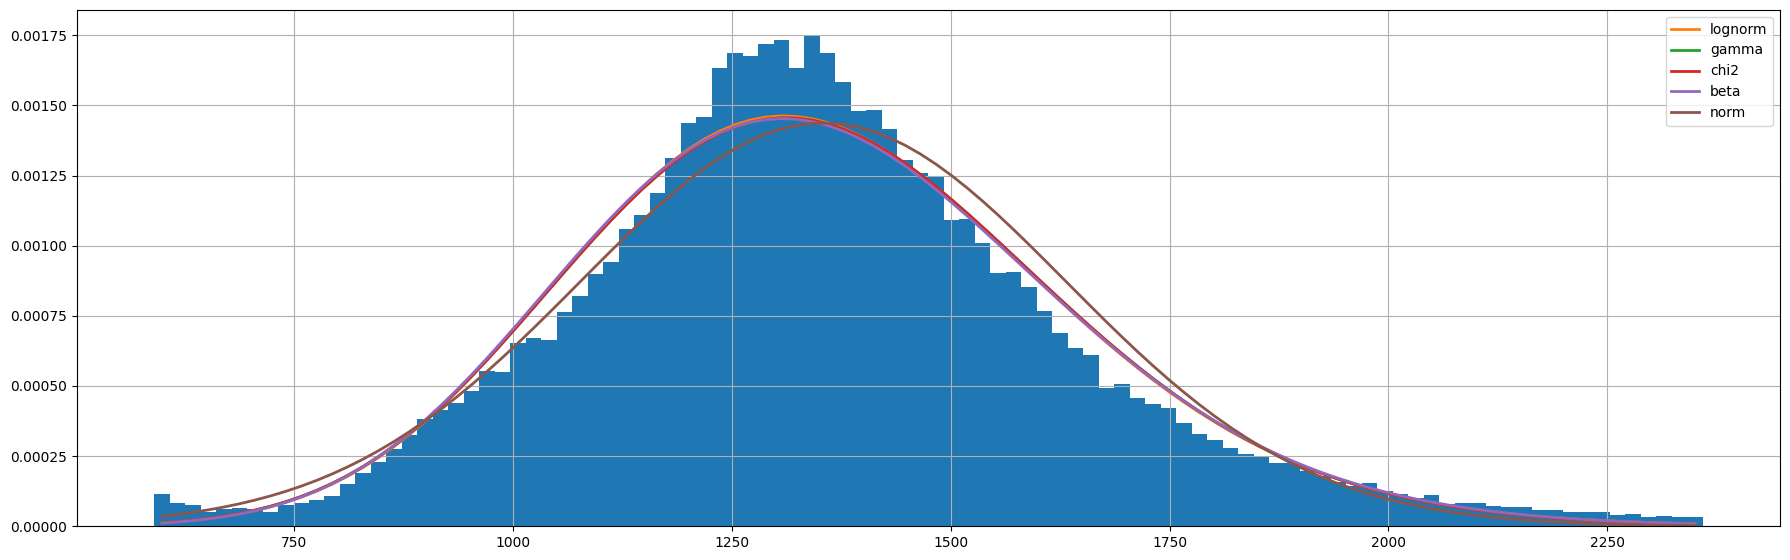

In [22]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/exploratory_data"

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'KI67_647: Nucleus: Median', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']


control_replicates = ["Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv", 
                      ]


fig, axs = plt.subplots(1, 4, figsize=(18, 6))

dfs = []
params_reference = None
threshold_reference = 40000

for idx, image in enumerate(control_replicates):

    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"
    print(gem_number)

    # Remove outliers using IQR for KER_488 intensities
    p01_KER = df['KER_488: Cytoplasm: Median'].quantile(0.01)
    p99_KER = df['KER_488: Cytoplasm: Median'].quantile(0.99)

    
    df_no_outlier = df[(df['KER_488: Cytoplasm: Median'] >= p01_KER) &
                       (df['KER_488: Cytoplasm: Median'] <= p99_KER)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['KER_488: Cytoplasm: Median'], binwidth=100, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.5)

    bins = []
    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins.append(axs[0].patches[-1].get_x() + (axs[0].patches[-1].get_width()))
    bins = np.sort(bins)
    
    print(len(bins))

    f = Fitter(df_no_outlier['KER_488: Cytoplasm: Median'],
               distributions= ["gamma", "invgauss", "lognorm", "beta", "burr", "norm", "expon", "rayleigh", "chi2", "exponpow"]
               )
    f.fit()
    summary = f.summary(clf=True)
    print(f.get_best(method = 'sumsquare_error'))
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('KER_488: Cytoplasm: Median', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240111_AsPC_pNDRG1/Results/20240222_plots/exploratory/20240301_distributions_allchannels_allcells_linear", dpi=300)
plt.show()

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1833588889.py:30: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
2024-04-25 17:57:27.423 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1833588889.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


#1
50
Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv
{'s': 0.5758167364961655, 'loc': 388.1739939268394, 'scale': 1476.1189489231276}
#2
77


2024-04-25 17:57:29.002 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1833588889.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv
{'s': 0.43515928988900693, 'loc': 576.4529130422418, 'scale': 972.4919093726185}
Translated threshold for img1: 947.05
Scaled threshold for img1: 847.77


2024-04-25 17:57:29.611 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


#3
518
Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv
{'s': 0.691958498984866, 'loc': -1028.5856381749359, 'scale': 9573.283963064056}
Translated threshold for img2: 1035.99
Scaled threshold for img2: 1642.29


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1833588889.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


#4
542


2024-04-25 17:57:31.220 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1833588889.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv
{'s': 0.2572099923502974, 'loc': -47.31216029253392, 'scale': 1714.6069038332787}
Translated threshold for img3: 922.12
Scaled threshold for img3: 431.05


2024-04-25 17:57:31.660 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


#5
563
Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv
{'s': 0.18801583465377916, 'loc': -509.3039310730005, 'scale': 2187.458399294605}
Translated threshold for img4: 932.53
Scaled threshold for img4: 100.98


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1833588889.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-04-25 17:57:32.132 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


#6
591
Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv
{'s': 0.18688633415953382, 'loc': -963.092526281225, 'scale': 2805.2080298229967}
Translated threshold for img5: 890.56
Scaled threshold for img5: -180.46


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1833588889.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-04-25 17:57:32.660 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


#7
619
Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv
{'s': 0.5640684671205329, 'loc': 490.0350249794584, 'scale': 747.1390412413639}
Translated threshold for img6: 703.98
Scaled threshold for img6: 698.48


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1833588889.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-04-25 17:57:33.222 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=1e-06)


#8
637
Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv
{'s': 0.10944986184212963, 'loc': -1167.9728296394062, 'scale': 2507.264383262676}
Translated threshold for img7: 799.10
Scaled threshold for img7: -468.47


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1833588889.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


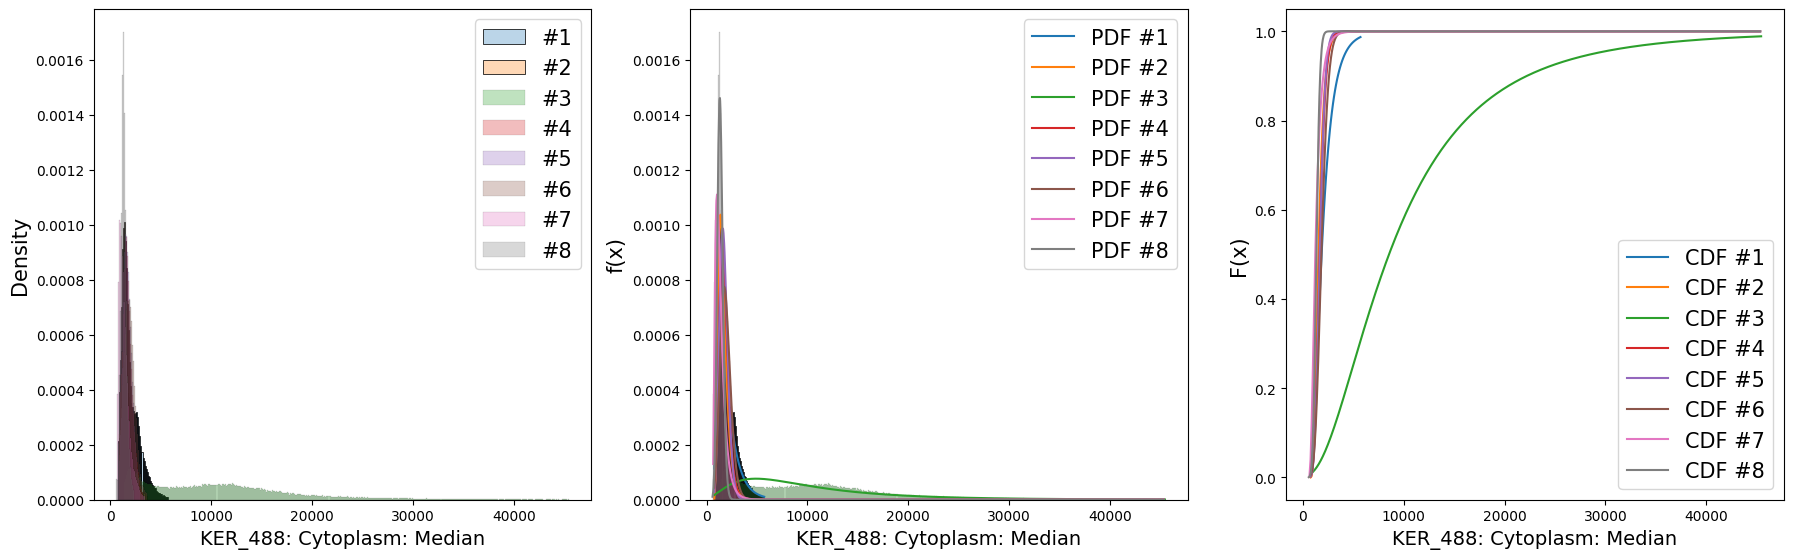

In [23]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/exploratory_data"

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'KI67_647: Nucleus: Median', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']


control_replicates = ["Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv", 
                      ]

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[2].clear()
dfs = []
params_reference = None
threshold_reference = 800

for idx, image in enumerate(control_replicates):

    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"
    print(gem_number)

    # Remove outliers using IQR for KER_488 intensities
    p01_KER = df['KER_488: Cytoplasm: Median'].quantile(0.01)
    p99_KER = df['KER_488: Cytoplasm: Median'].quantile(0.99)

    
    df_no_outlier = df[(df['KER_488: Cytoplasm: Median'] >= p01_KER) &
                       (df['KER_488: Cytoplasm: Median'] <= p99_KER) 
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['KER_488: Cytoplasm: Median'], binwidth=100, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.3, stat='density')

    bins = []
    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins.append(axs[0].patches[-1].get_x() + (axs[0].patches[-1].get_width()))
    bins = np.sort(bins)
    
    print(len(bins))

    f = Fitter(df_no_outlier['KER_488: Cytoplasm: Median'],
               distributions=['lognorm']
               )
    f.fit()
    summary = f.summary(clf=False)
    sse = "{:.2e}".format(summary['sumsquare_error'][0])
    params = f.get_best(method = 'sumsquare_error')
    params = params.get('lognorm')
    print(image)
    print(params)

    if idx == 0: 
        params_reference = params
    else: 
        # Get the percentile for this threshold
        cdf_reference = lognorm.cdf(threshold_reference, **params_reference)
        # Translate this percentile onto the distribution of reference by using the inverse CDF and get back a value from the percentile
        translated_threshold = lognorm.ppf(cdf_reference, **params)       
        print(f"Translated threshold for img{idx}: {translated_threshold:.2f}")
        # Scale the data point using the parameters of the target distribution
        scaled_threshold = (threshold_reference - params_reference['loc']) * (params['scale'] / params_reference['scale']) + params['loc']
        print(f"Scaled threshold for img{idx}: {scaled_threshold:.2f}")

    cdf_values = lognorm.cdf(bins, **params)
    pdf_values = lognorm.pdf(bins, **params)

    # Plot the line of the log-normal distribution
    sns.histplot(df_no_outlier['KER_488: Cytoplasm: Median'], binwidth=100, kde=False, ax=axs[1], alpha=0.3, stat='density')
    axs[1].plot(bins, pdf_values, label=f"PDF {gem_number}")
    axs[2].plot(bins, cdf_values, label=f"CDF {gem_number}")
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('KER_488: Cytoplasm: Median', fontsize=14)

axs[1].legend(fontsize=15)
axs[1].set_ylabel('f(x)', fontsize=15)
axs[1].set_xlabel('KER_488: Cytoplasm: Median', fontsize=14)

axs[2].legend(fontsize=15)
axs[2].set_ylabel(r'F(x)', fontsize=15)
axs[2].set_xlabel('KER_488: Cytoplasm: Median', fontsize=14)

axs[3].remove()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_KER_SW1990_lognormal.png", dpi=300)
plt.show()

### FN_648

#### Finding the right distribution; result: lognorm (4 out of 8)

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/1194904859.py:30: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
2024-04-25 18:10:35.125 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=5e-06)
2024-04-25 18:10:35.129 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=6e-06)


#1
55


2024-04-25 18:10:35.187 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2e-06)
2024-04-25 18:10:35.395 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 18:10:35.718 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 18:10:36.287 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=3e-05)
2024-04-25 18:10:36.503 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=1e-06)
2024-04-25 18:10:36.567 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=4e-06)
2024-04-25 18:10:37.249 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 18:10:40.698 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with err

{'lognorm': {'s': 0.6181612545446984, 'loc': 304.01979895612936, 'scale': 598.3842816896899}}
#2
161


2024-04-25 18:10:42.134 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1e-06)
2024-04-25 18:10:42.157 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-04-25 18:10:42.226 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)
2024-04-25 18:10:42.493 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 18:10:43.666 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 18:10:44.897 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-04-25 18:10:45.443 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-04-25 18:10:45.887 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=

{'beta': {'a': 1.2581139237029912, 'b': 158.25465532531024, 'loc': 442.1963605802082, 'scale': 210369.61089716142}}


2024-04-25 18:10:54.639 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=2e-06)
2024-04-25 18:10:54.640 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=2e-06)
2024-04-25 18:10:54.677 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)


#3
237


2024-04-25 18:10:54.800 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 18:10:55.144 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 18:10:55.751 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1.5e-05)
2024-04-25 18:10:55.941 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-04-25 18:10:56.434 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 18:10:56.643 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)
2024-04-25 18:10:58.920 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'gamma': {'a': 1.613517282961637, 'loc': 516.5673239272385, 'scale': 514.6161930374255}}
#4
523


2024-04-25 18:11:00.241 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)
2024-04-25 18:11:00.241 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=1e-06)
2024-04-25 18:11:00.358 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)
2024-04-25 18:11:00.445 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 18:11:03.501 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1e-06)
2024-04-25 18:11:03.515 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 18:11:03.841 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-04-25 18:11:04.420 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=

{'lognorm': {'s': 1.094133524371711, 'loc': 617.7638392638514, 'scale': 1795.6147853317818}}
#5


2024-04-25 18:11:13.628 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=5e-06)
2024-04-25 18:11:13.631 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=6e-06)
2024-04-25 18:11:13.654 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=3e-06)
2024-04-25 18:11:13.733 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


575


2024-04-25 18:11:14.340 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=3.5e-05)
2024-04-25 18:11:14.489 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=3.5e-05)
2024-04-25 18:11:14.582 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=1e-06)
2024-04-25 18:11:14.861 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=1e-06)
2024-04-25 18:11:14.945 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=4e-06)
2024-04-25 18:11:16.434 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=1e-06)


{'lognorm': {'s': 0.6322723176427341, 'loc': 310.1385295393987, 'scale': 531.4556964000733}}


2024-04-25 18:11:16.876 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=2e-06)
2024-04-25 18:11:16.877 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=2e-06)
2024-04-25 18:11:16.905 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=1e-06)


#6
660


2024-04-25 18:11:17.015 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 18:11:17.279 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 18:11:17.729 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=1.1e-05)
2024-04-25 18:11:17.839 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-04-25 18:11:18.250 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 18:11:18.370 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=1e-06)
2024-04-25 18:11:20.120 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=0.0)


{'lognorm': {'s': 0.5977915359156355, 'loc': 332.7611725196547, 'scale': 1034.6406721061805}}


2024-04-25 18:11:20.594 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=5e-06)
2024-04-25 18:11:20.596 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1.2e-05)
2024-04-25 18:11:20.622 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=2e-06)


#7
698


2024-04-25 18:11:20.733 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-25 18:11:21.002 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-25 18:11:21.535 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)
2024-04-25 18:11:21.698 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=0.0)
2024-04-25 18:11:22.128 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=5.3e-05)
2024-04-25 18:11:22.314 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=0.0)
2024-04-25 18:11:24.457 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=2e-06)


{'beta': {'a': 1.9985391016897989, 'b': 26.067215761649358, 'loc': 388.74681977124715, 'scale': 6998.12874310627}}


2024-04-25 18:11:24.930 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=7e-06)
2024-04-25 18:11:24.935 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=6e-06)
2024-04-25 18:11:24.958 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=5e-06)
2024-04-25 18:11:25.033 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=1e-06)


#8
776


2024-04-25 18:11:25.280 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=2e-06)
2024-04-25 18:11:25.755 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=2e-06)
2024-04-25 18:11:25.973 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted invgauss distribution with error=1e-06)
2024-04-25 18:11:26.502 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=3e-06)
2024-04-25 18:11:26.611 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted exponpow distribution with error=6e-06)
2024-04-25 18:11:28.972 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted burr distribution with error=1e-06)


{'invgauss': {'mu': 0.6835716335364972, 'loc': 238.46704432837203, 'scale': 1281.4995090684151}}


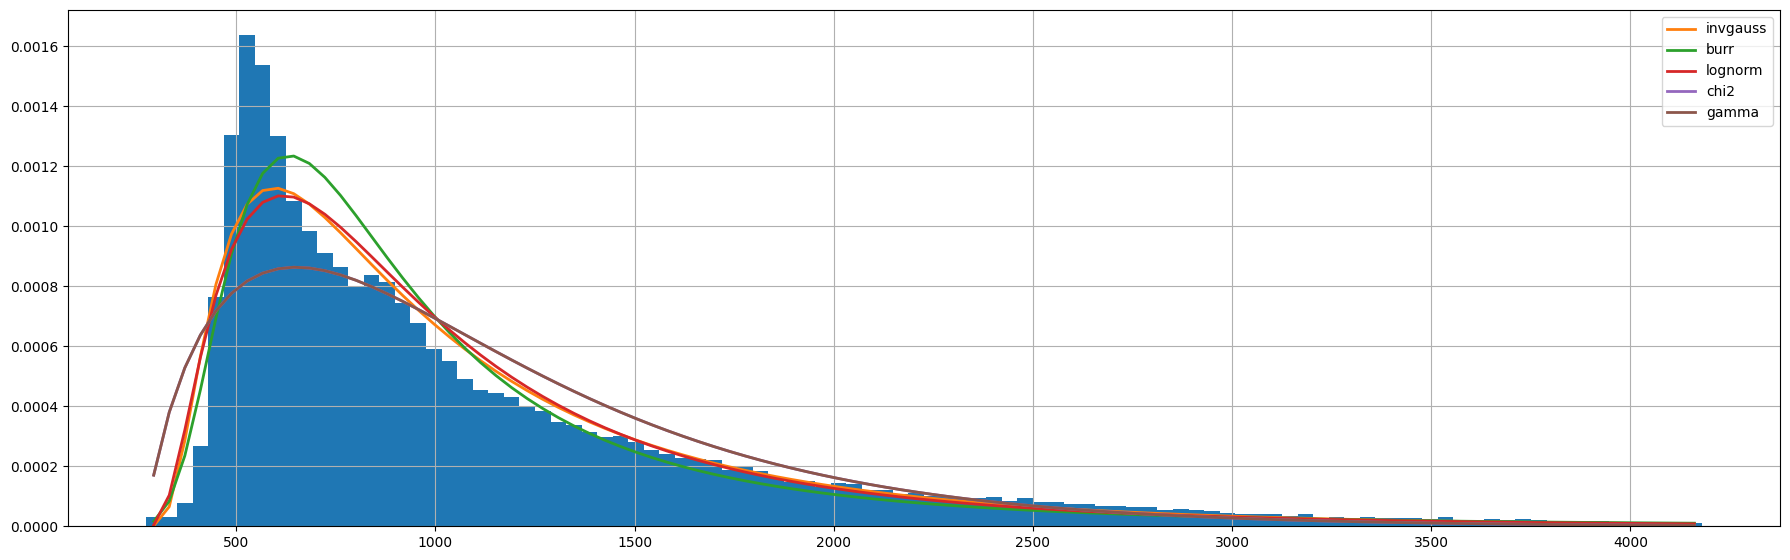

In [24]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/exploratory_data"

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'KI67_647: Nucleus: Median', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']


control_replicates = ["Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv", 
                      ]

fig, axs = plt.subplots(1, 4, figsize=(18, 6))

dfs = []
params_reference = None
threshold_reference = 1500

for idx, image in enumerate(control_replicates):

    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"
    print(gem_number)

    # Remove outliers using IQR for KER_488 intensities
    p01_FN = df['FN_568: Cell: Median'].quantile(0.01)
    p99_FN = df['FN_568: Cell: Median'].quantile(0.99)
    
    df_no_outlier = df[(df['FN_568: Cell: Median'] >= p01_FN) &
                       (df['FN_568: Cell: Median'] <= p99_FN) 
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['FN_568: Cell: Median'], binwidth=50, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.5)

    bins = []
    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins.append(axs[0].patches[-1].get_x() + (axs[0].patches[-1].get_width()))
    bins = np.sort(bins)
    
    print(len(bins))

    f = Fitter(df_no_outlier['FN_568: Cell: Median'],
               distributions= ["gamma", "invgauss", "lognorm", "beta", "burr", "norm", "expon", "rayleigh", "chi2", "exponpow"]
               )
    f.fit()
    summary = f.summary(clf=True)
    print(f.get_best(method = 'sumsquare_error'))
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('FN_568: Cell: Median', fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240111_AsPC_pNDRG1/Results/20240222_plots/exploratory/20240301_distributions_allchannels_allcells_linear", dpi=300)
plt.show()

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/2430869416.py:30: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)


#1
55


2024-04-25 18:11:59.786 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/2430869416.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'lognorm': {'s': 0.6181612545446984, 'loc': 304.01979895612936, 'scale': 598.3842816896899}}
Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv
#2
215


2024-04-25 18:12:01.455 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/2430869416.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'lognorm': {'s': 0.7870400890386409, 'loc': 238.2644415357676, 'scale': 1391.309583448359}}
Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv
Translated threshold for img1: 3598.19
Scaled threshold for img1: 3019.05


2024-04-25 18:12:02.117 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


#3
291
{'lognorm': {'s': 0.665104629932382, 'loc': 376.43562463138903, 'scale': 785.828586925087}}
Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv
Translated threshold for img2: 2031.86
Scaled threshold for img2: 1947.06


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/2430869416.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


#4
577


2024-04-25 18:12:03.569 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/2430869416.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


{'lognorm': {'s': 1.094133524371711, 'loc': 617.7638392638514, 'scale': 1795.6147853317818}}
Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv
Translated threshold for img3: 6734.56
Scaled threshold for img3: 4206.63


2024-04-25 18:12:04.068 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


#5
629
{'lognorm': {'s': 0.6322723176427341, 'loc': 310.1385295393987, 'scale': 531.4556964000733}}
Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv
Translated threshold for img4: 1389.27
Scaled threshold for img4: 1372.35


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/2430869416.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-04-25 18:12:04.597 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


#6
714
{'lognorm': {'s': 0.5977915359156355, 'loc': 332.7611725196547, 'scale': 1034.6406721061805}}
Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv
Translated threshold for img5: 2354.03
Scaled threshold for img5: 2400.68


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/2430869416.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-04-25 18:12:05.130 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)


#7
752
{'lognorm': {'s': 0.5130171080367344, 'loc': 246.78120871282562, 'scale': 562.8529830240415}}
Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv
Translated threshold for img6: 1246.75
Scaled threshold for img6: 1371.75


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/2430869416.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])
2024-04-25 18:12:05.927 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=1e-06)


#8
830
{'lognorm': {'s': 0.7666306555065593, 'loc': 265.1671435031847, 'scale': 633.2957058371517}}
Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv
Translated threshold for img7: 1759.97
Scaled threshold for img7: 1530.92


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_36452/2430869416.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sse = "{:.2e}".format(summary['sumsquare_error'][0])


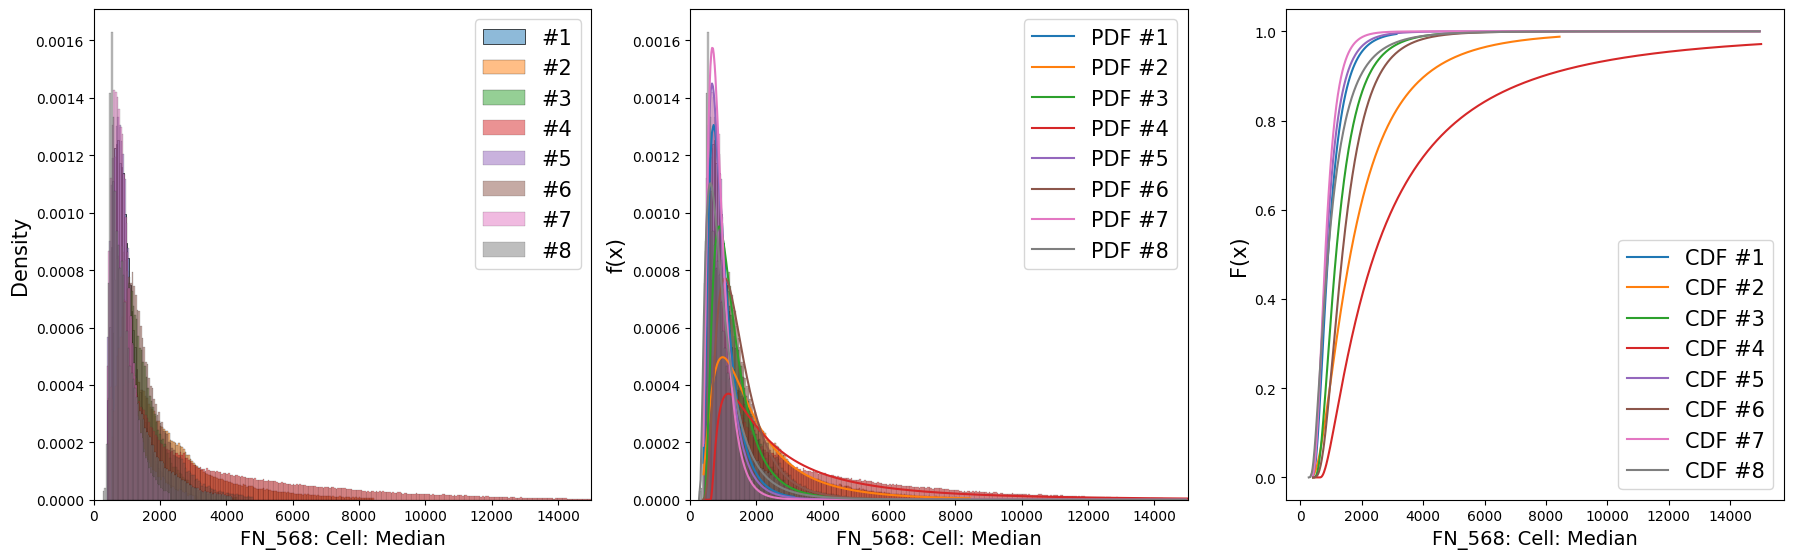

In [25]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/exploratory_data"

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'KI67_647: Nucleus: Median', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2']


control_replicates = ["Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv", 
                      ]

fig, axs = plt.subplots(1, 4, figsize=(24, 6))

dfs = []
params_reference = None
threshold_reference = 1500

for idx, image in enumerate(control_replicates):

    df = pd.read_csv(os.path.join(folder_path, image), usecols=columns_to_load)
    gem_number = f"#{idx + 1}"
    print(gem_number)

    # Remove outliers using IQR for pNDRG1_647 intensities
    p01_pNDRG1 = df['FN_568: Cell: Median'].quantile(0.01)
    p99_pNDRG1 = df['FN_568: Cell: Median'].quantile(0.99)
    
    df_no_outlier = df[(df['FN_568: Cell: Median'] >= p01_pNDRG1) & 
                       (df['FN_568: Cell: Median'] <= p99_pNDRG1)
                       ]

    # Plot signed distance distribution for each image (outliers removed)
    sns.histplot(df_no_outlier['FN_568: Cell: Median'], binwidth=50, kde=False, ax=axs[0], label=f'{gem_number}', alpha=0.5, stat='density')

    bins = []
    # Retrieve the heights of the bars
    heights = [rect.get_height() for rect in axs[0].patches]
    # Retrieve the bin edges (x-values)
    bins = [rect.get_x() for rect in axs[0].patches]
    bins.append(axs[0].patches[-1].get_x() + (axs[0].patches[-1].get_width()))
    bins = np.sort(bins)
    
    print(len(bins))

    f = Fitter(df_no_outlier['FN_568: Cell: Median'],
               distributions=['lognorm']
               )
    f.fit()
    summary = f.summary(clf=False)
    sse = "{:.2e}".format(summary['sumsquare_error'][0])
    params = f.get_best(method = 'sumsquare_error')
    params = params.get('lognorm')
    print(f.get_best(method = 'sumsquare_error'))
    print(image)

    if idx == 0: 
        params_reference = params
    else: 
        # Get the percentile for this threshold
        cdf_reference = lognorm.cdf(threshold_reference, **params_reference)
        # Translate this percentile onto the distribution of reference by using the inverse CDF and get back a value from the percentile
        translated_threshold = lognorm.ppf(cdf_reference, **params)       
        print(f"Translated threshold for img{idx}: {translated_threshold:.2f}")
        # Scale the data point using the parameters of the target distribution
        scaled_threshold = (threshold_reference - params_reference['loc']) * (params['scale'] / params_reference['scale']) + params['loc']
        print(f"Scaled threshold for img{idx}: {scaled_threshold:.2f}")

    cdf_values = lognorm.cdf(bins, **params)
    pdf_values = lognorm.pdf(bins, **params)

    # Plot the line of the log-normal distribution
    sns.histplot(df_no_outlier['FN_568: Cell: Median'], binwidth=50, kde=False, ax=axs[1], alpha=0.5, stat='density')
    axs[1].plot(bins, pdf_values, label=f"PDF {gem_number}")
    axs[2].plot(bins, cdf_values, label=f'CDF {gem_number}')
    
    dfs.append(df_no_outlier)

dfs_data = pd.concat(dfs, ignore_index=True)

axs[0].legend(fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].set_xlabel('FN_568: Cell: Median', fontsize=14)
axs[0].set_xlim([0, 15000])

axs[1].legend(fontsize=15)
axs[1].set_ylabel(r'f(x)', fontsize=15)
axs[1].set_xlabel('FN_568: Cell: Median', fontsize=14)
axs[1].set_xlim([0, 15000])

axs[2].legend(fontsize=15)
axs[2].set_ylabel(r'F(x)', fontsize=15)
axs[2].set_xlabel('FN_568: Cell: Median', fontsize=14)
#axs[2].set_xlim([0, 15000])

axs[3].remove()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/plots/exploratory/20240315_FN647_SW1990_median_lognormal.png", dpi=300)
plt.show()